In [1]:
import numpy as np
import xarray as xr
from matplotlib import  pyplot as plt
import pandas as pd
import urllib
import cartopy.crs as ccrs
import datetime
from matplotlib import ticker
import os, sys
import pickle
import glob
from scipy.optimize import minimize
from os import path
from datetime import timedelta
from datetime import datetime
import cartopy.feature as cfeature
from matplotlib.ticker import FormatStrFormatter
import WetBulb
from scipy.stats import gaussian_kde
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.patches import Polygon
from tqdm import tqdm

In [2]:
# Define function for stickiness
def stickiness(T,q):
    v = [1.199557787089589, -7.75269363e+02, 3.02416275e-01, 3.08627625e+00,
              7.74095672e+03, 1.78241619e-03, -2.38012318e+02, -4.98714576e-01,
              2.40170949e+01, 7.18600120e+03, -2.75682633e-05, 4.29814844e+02,
              7.01883383e-03, -2.83672170e+02, -3.67109506e-01, 5.09430371e+00]
    
    stick = -1*(v[0] + v[1]*q + v[2]*T + v[3]*q*T + 
             v[4]*q**2 + v[5]*T**2 + v[6]*(q**2)*T + 
             v[7]*(T**2)*q + v[8]*(q**2)*(T**2) + 
             v[9]*q**3 + v[10]*T**3 + v[11]*(q**3)*T + 
             v[12]*(T**3)*q + v[13]*(q**3)*(T**2) + 
             v[14]*(T**3)*(q**2) + v[15]*(q**3)*(T**3))
    
    return stick

# Figure S16

In [4]:
col_names = ['stncodes','stnlats','stnlons','stnelevs']
stndata = pd.read_csv('/home/ivanov/matlab/Code/MJO_TW/hadisd_station_metadata_v2019.txt', delimiter = '\s+', header = None, names = col_names)

# Get individual pieces of station data
stncodes = stndata.stncodes.values
stnlats = stndata.stnlats.values
stnlons = stndata.stnlons.values
stnelevs = stndata.stnelevs.values

In [5]:
percent_high = pd.read_csv("/dx01/ivanov/data/HadISD_stationdata/Spice/overlap_high_2_allstations.csv", index_col = False, header = None,delimiter = '\t')
percent_high_nan = pd.read_csv("/dx01/ivanov/data/HadISD_stationdata/Spice/overlap_highnan_2_allstations.csv", index_col = False, header = None,delimiter = '\t')

percent_low = pd.read_csv("/dx01/ivanov/data/HadISD_stationdata/Spice/overlap_low_2_allstations.csv", index_col = False, header = None,delimiter = '\t')
percent_low_nan = pd.read_csv("/dx01/ivanov/data/HadISD_stationdata/Spice/overlap_lownan_2_allstations.csv", index_col = False, header = None,delimiter = '\t')

In [8]:
TW = pd.read_csv('/dx01/ivanov/data/HadISD_stationdata/Spice/matcheddates_TW_allstations.csv', index_col = 0, delimiter = '\t')
print('tw loaded')
Tmax = pd.read_csv("/dx01/ivanov/data/HadISD_stationdata/Spice/matcheddates_Tmax_allstations.csv", index_col = 0, delimiter = '\t')
print('Tmax loaded')
simulT = pd.read_csv("/dx01/ivanov/data/HadISD_stationdata/Spice/matcheddates_simulT_allstations.csv", index_col = 0, delimiter = '\t')
print('T loaded')
simulSH = pd.read_csv("/dx01/ivanov/data/HadISD_stationdata/Spice/matcheddates_simulSH_allstations.csv", index_col = 0, delimiter = '\t')
print('q loaded')

tw loaded
Tmax loaded
T loaded
q loaded


In [10]:
v = [0, -7.75269363e+02, 3.02416275e-01, 3.08627625e+00,7.74095672e+03, 1.78241619e-03, -2.38012318e+02, -4.98714576e-01,2.40170949e+01, 7.18600120e+03, -2.75682633e-05, 4.29814844e+02,7.01883383e-03, -2.83672170e+02, -3.67109506e-01, 5.09430371e+00]

percent_high = 0*stnlats
percent_high_nan = 0*stnlats

percent_low = 0*stnlats
percent_low_nan = 0*stnlats

len_high = 0*stnlats
len_low = 0*stnlats

TW99 = 0*stnlats
T99 = 0*stnlats

for stn in range(len(stnlats)):
        
    if stncodes[stn] in TW.columns:
    
        TW_stn = TW[stncodes[stn]]
        Tmax_stn = Tmax[stncodes[stn]]
        simulT_stn = simulT[stncodes[stn]]
        simulSH_stn = simulSH[stncodes[stn]]

        # Find extreme T and Tw percentiles
        prctl = 0.95

        TW99[stn] = TW_stn.quantile(prctl)
        T99[stn] = Tmax_stn.quantile(prctl)

        # Calculate station stickiness array
        stick = -1*(v[0] + v[1]*simulSH_stn + v[2]*simulT_stn + v[3]*simulSH_stn*simulT_stn + 
                 v[4]*simulSH_stn**2 + v[5]*simulT_stn**2 + v[6]*(simulSH_stn**2)*simulT_stn + 
                 v[7]*(simulT_stn**2)*simulSH_stn + v[8]*(simulSH_stn**2)*(simulT_stn**2) + 
                 v[9]*simulSH_stn**3 + v[10]*simulT_stn**3 + v[11]*(simulSH_stn**3)*simulT_stn + 
                 v[12]*(simulT_stn**3)*simulSH_stn + v[13]*(simulSH_stn**3)*(simulT_stn**2) + 
                 v[14]*(simulT_stn**3)*(simulSH_stn**2) + v[15]*(simulSH_stn**3)*(simulT_stn**3))

        # Select high and low stick days
        high_cutoff = 3
        low_cutoff = -3

        highstick_TW = TW_stn[stick >= high_cutoff]
        highstick_Tmax = Tmax_stn[stick >= high_cutoff]

        lowstick_TW = TW_stn[stick <= low_cutoff]
        lowstick_Tmax = Tmax_stn[stick <= low_cutoff]

        # Find data above percentiles 
        high_TWdays = highstick_TW[highstick_TW >= TW99[stn]]
        high_Tdays = highstick_Tmax[highstick_Tmax >= T99[stn]]
        high_intersect = highstick_TW[(highstick_TW >= TW99[stn]) & (highstick_Tmax >= T99[stn])]

        low_TWdays = lowstick_TW[lowstick_TW >= TW99[stn]]
        low_Tdays = lowstick_Tmax[lowstick_Tmax >= T99[stn]]
        low_intersect = lowstick_TW[(lowstick_TW >= TW99[stn]) & (lowstick_Tmax >= T99[stn])]

        # Calculate percent overlap
        # Put 999 if there are no extreme Tw days in the category
        if len(high_TWdays) > 0:
            percent_high[stn] = len(high_intersect)/len(high_TWdays)
            percent_high_nan[stn] = np.NaN
        if len(high_TWdays) == 0:
            percent_high[stn] = np.NaN
            percent_high_nan[stn] = 999

        if len(low_TWdays) > 0:
            percent_low[stn] = len(low_intersect)/len(low_TWdays)
            percent_low_nan[stn] = np.NaN
        if len(low_TWdays) == 0:
            percent_low[stn] = np.NaN
            percent_low_nan[stn] = 999
            
        len_high[stn] = len(high_TWdays)
        len_low[stn] = len(low_TWdays)
            
    else:
        # Put 555 wherever station data does not exist
        percent_high[stn] = 555
        percent_high_nan[stn] = 555
        percent_low[stn] = 555
        percent_low_nan[stn] = 555

In [11]:
high_data = pd.DataFrame({'High Overlap': percent_high, 'High NaN': percent_high_nan, 'Lat': stnlats, 'Lon': stnlons, 'TW99': TW99, 'T99': T99})
low_data = pd.DataFrame({'Low Overlap': percent_low, 'Low NaN': percent_low_nan, 'Lat': stnlats, 'Lon': stnlons, 'TW99': TW99, 'T99': T99})

low_data_no555 = low_data[low_data['Low NaN'] != 555]
high_data_no555 = high_data[high_data['High NaN'] != 555]

# Select full or empty points
high_full = high_data_no555[high_data_no555['High NaN'] != 999]
high_empty = high_data_no555[high_data_no555['High NaN'] == 999]

low_full = low_data_no555[low_data_no555['Low NaN'] != 999]
low_empty = low_data_no555[low_data_no555['Low NaN'] == 999]

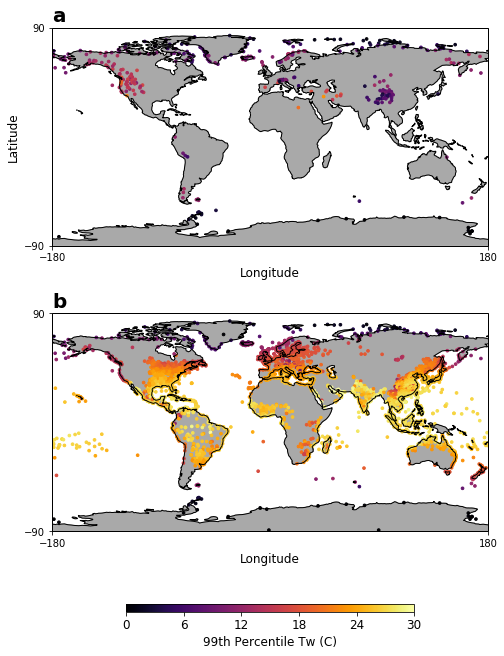

In [12]:
import string

fig, axs = plt.subplots(2,1,figsize = (8,9), facecolor = 'w', edgecolor = 'k', constrained_layout=True, subplot_kw = {'projection': ccrs.PlateCarree()})

plt.rcParams.update({'font.size': 12})

# Plot high stick data
high_scat = axs[0].scatter(high_empty['Lon'],high_empty['Lat'], c = high_empty['TW99'], cmap = 'inferno', s = 7, vmin = 0, vmax = 30)

axs[0].set_ylabel('Latitude', fontsize = 12)
axs[0].set_xlabel('Longitude', fontsize = 12)
axs[0].coastlines(linewidth=1)
axs[0].set_xticks([-180,180], crs=ccrs.PlateCarree())
axs[0].set_yticks([-90,90], crs=ccrs.PlateCarree())
axs[0].set_xlim(-180,180)
axs[0].set_ylim(-90,90)
axs[0].add_feature(cfeature.LAND, facecolor = 'darkgrey')

axs[0].text(-180, 95, string.ascii_lowercase[0], size=20, weight='bold')

# Plot low stick data
low_scat = axs[1].scatter(low_empty['Lon'],low_empty['Lat'], c = low_empty['TW99'], cmap = 'inferno', s = 7, vmin = 0, vmax = 30)

axs[1].set_xlabel('Longitude', fontsize = 12)
axs[1].coastlines(linewidth=1)
axs[1].set_xticks([-180,180], crs=ccrs.PlateCarree())
axs[1].set_yticks([-90,90], crs=ccrs.PlateCarree())
axs[1].set_xlim(-180,180)
axs[1].set_ylim(-90,90)
axs[1].add_feature(cfeature.LAND, facecolor = 'darkgrey')

axs[1].text(-180, 95, string.ascii_lowercase[1], size=20, weight='bold')

cbar = plt.colorbar(low_scat, ax=axs.ravel().tolist(), shrink = 0.5, location = 'bottom', pad = 0.05)
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.set_label('99th Percentile Tw (C)', fontsize = 12)
plt.show()

# Figure S17

In [13]:
data_dir = "/dx01/ivanov/data/HadISD_stationdata/Spice/"
allstn_data = pd.read_csv(data_dir + 'stn_mean_stick_Twranges.csv', index_col = 0)

In [14]:
allstn_data = allstn_data.rename(columns={"stn_code": "stncodes"})
allstn_data = allstn_data.set_index('stncodes')
stndata_stncodes = stndata.set_index('stncodes')

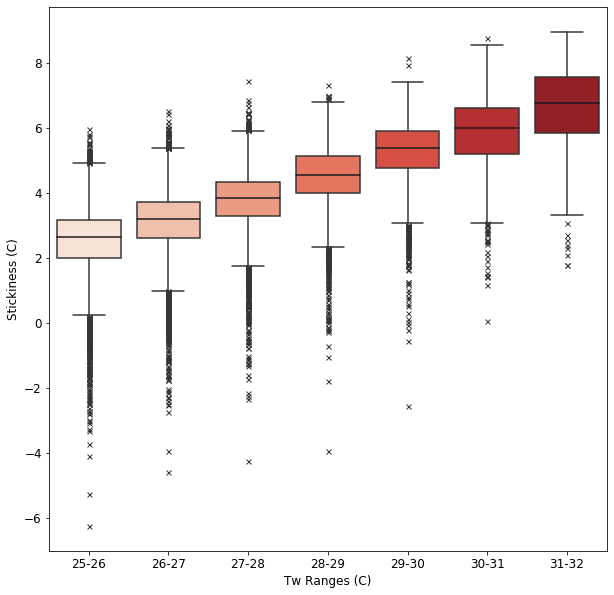

In [15]:
import seaborn as sns

fig, axs = plt.subplots(1,1, figsize = [10,10])

sns.set(font_scale=1.5)

sns.boxplot(data =allstn_data, palette = 'Reds', medianprops={"color": "k"}, flierprops={"marker": "x"})
plt.xlabel("Tw Ranges (C)")
plt.ylabel("Stickiness (C)")

sns.set_theme(style='white')
                
plt.show()

# Figure S21

In [16]:
# Select stations in each region
SE_SD_lons = [-100,-96]
SE_SD_lats = [43,44.5]

NE_MO_lons = [-94,-92]
NE_MO_lats = [38,41]

SE_SD_stns = stndata[(stndata.stnlats > SE_SD_lats[0]) & (stndata.stnlats < SE_SD_lats[1])
                    & (stndata.stnlons > SE_SD_lons[0]) & (stndata.stnlons < SE_SD_lons[1])].stncodes

NE_MO_stns = stndata[(stndata.stnlats > NE_MO_lats[0]) & (stndata.stnlats < NE_MO_lats[1])
                    & (stndata.stnlons > NE_MO_lons[0]) & (stndata.stnlons < NE_MO_lons[1])].stncodes

sioux_falls_stn ='999999-04990'
columbia_stn = '725510-14939'
dallas_stn = '722590-03927'
phoenix_stn = '722780-23183'

In [22]:
TW_data = TW
simulT_data = simulT
simulq_data = simulSH

In [23]:
TW_SD = TW_data[[sioux_falls_stn,'Date']]
TW_SD = TW_SD.rename(columns={sioux_falls_stn: "TW"})
T_SD = simulT_data[[sioux_falls_stn,'Date']]
T_SD = T_SD.rename(columns={sioux_falls_stn: "T"})
q_SD = simulq_data[[sioux_falls_stn,'Date']]
q_SD = q_SD.rename(columns={sioux_falls_stn: "q"})

TW_MO = TW_data[[columbia_stn,'Date']]
TW_MO = TW_MO.rename(columns={columbia_stn: "TW"})
T_MO = simulT_data[[columbia_stn,'Date']]
T_MO = T_MO.rename(columns={columbia_stn: "T"})
q_MO = simulq_data[[columbia_stn,'Date']]
q_MO = q_MO.rename(columns={columbia_stn: "q"})

TW_TX = TW_data[[dallas_stn,'Date']]
TW_TX = TW_TX.rename(columns={dallas_stn: "TW"})
T_TX = simulT_data[[dallas_stn,'Date']]
T_TX = T_TX.rename(columns={dallas_stn: "T"})
q_TX = simulq_data[[dallas_stn,'Date']]
q_TX = q_TX.rename(columns={dallas_stn: "q"})

TW_AZ = TW_data[[phoenix_stn,'Date']]
TW_AZ = TW_AZ.rename(columns={phoenix_stn: "TW"})
T_AZ = simulT_data[[phoenix_stn,'Date']]
T_AZ = T_AZ.rename(columns={phoenix_stn: "T"})
q_AZ = simulq_data[[phoenix_stn,'Date']]
q_AZ = q_AZ.rename(columns={phoenix_stn: "q"})

In [26]:
# Break date into month and year
sioux_falls_data = pd.concat([TW_SD, T_SD['T'], q_SD['q']], axis=1)
sioux_falls_data['Date'] = sioux_falls_data['Date'].astype('datetime64[ns]')
sioux_falls_data['month'] = sioux_falls_data['Date'].dt.month
sioux_falls_data['year'] = sioux_falls_data['Date'].dt.year

columbia_data = pd.concat([TW_MO, T_MO['T'], q_MO['q']], axis=1)
columbia_data['Date'] = columbia_data['Date'].astype('datetime64[ns]')
columbia_data['month'] = columbia_data['Date'].dt.month
columbia_data['year'] = columbia_data['Date'].dt.year

# Select only 2011 and 2012 summers
sioux_falls_summers = sioux_falls_data[sioux_falls_data['month'].isin([6,7,8])]
columbia_summers = columbia_data[columbia_data['month'].isin([6,7,8])]

sioux_falls_summers['stick'] = stickiness(sioux_falls_summers['T'],sioux_falls_summers['q'])
columbia_summers['stick'] = stickiness(columbia_summers['T'],columbia_summers['q'])

sioux_falls_2011 = sioux_falls_summers[sioux_falls_summers['year'] == 2011]
sioux_falls_2012 = sioux_falls_summers[sioux_falls_summers['year'] == 2012]

columbia_2011 = columbia_summers[columbia_summers['year'] == 2011]
columbia_2012 = columbia_summers[columbia_summers['year'] == 2012]

dallas_data = pd.concat([TW_TX, T_TX['T'], q_TX['q']], axis=1)
dallas_data['Date'] = dallas_data['Date'].astype('datetime64[ns]')
dallas_data['month'] = dallas_data['Date'].dt.month
dallas_data['year'] = dallas_data['Date'].dt.year

phoenix_data = pd.concat([TW_AZ, T_AZ['T'], q_AZ['q']], axis=1)
phoenix_data['Date'] = phoenix_data['Date'].astype('datetime64[ns]')
phoenix_data['month'] = phoenix_data['Date'].dt.month
phoenix_data['year'] = phoenix_data['Date'].dt.year

dallas_summers = dallas_data[dallas_data['month'].isin([6,7,8])]
phoenix_summers = phoenix_data[phoenix_data['month'].isin([6,7,8])]

dallas_summers['stick'] = stickiness(dallas_summers['T'],dallas_summers['q'])
phoenix_summers['stick'] = stickiness(phoenix_summers['T'],phoenix_summers['q'])

dallas_2011 = dallas_summers[dallas_summers['year'] == 2011]
dallas_2012 = dallas_summers[dallas_summers['year'] == 2012]

phoenix_2011 = phoenix_summers[phoenix_summers['year'] == 2011]
phoenix_2012 = phoenix_summers[phoenix_summers['year'] == 2012]

/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/sw/anaconda3/envs/pangeoxtd36/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

(-14, 6)

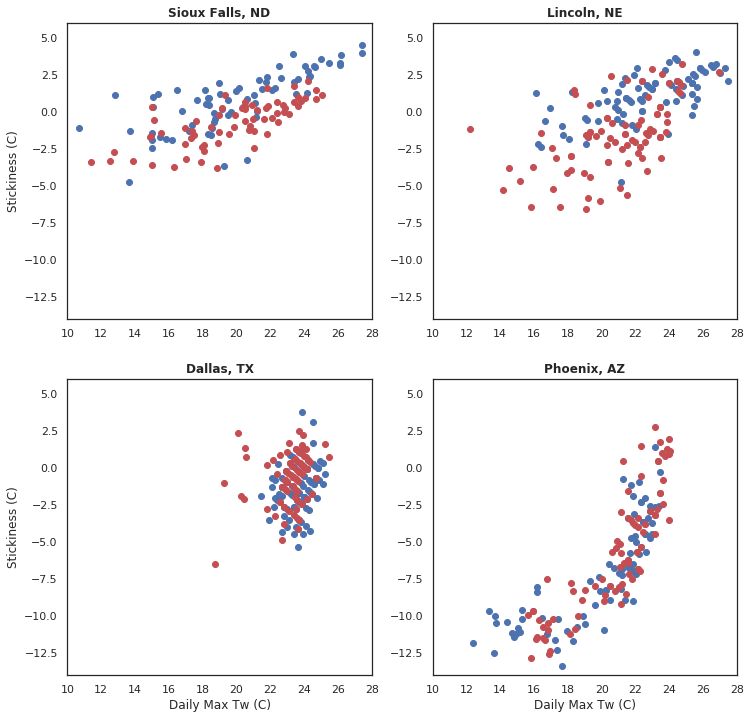

In [27]:
fig, axs = plt.subplots(2,2, figsize = (12, 12))

scat_2011 = axs[0,0].scatter(sioux_falls_2011['TW'],sioux_falls_2011['stick'], color = 'b')
scat_2012 = axs[0,0].scatter(sioux_falls_2012['TW'],sioux_falls_2012['stick'], color = 'r')
axs[0,0].set_ylabel('Stickiness (C)')
axs[0,0].set_title('Sioux Falls, ND', fontweight = 'bold')
axs[0,0].set_xlim([10,28])
axs[0,0].set_ylim([-14,6])

scat_2011 = axs[0,1].scatter(columbia_2011['TW'],columbia_2011['stick'], color = 'b')
scat_2012 = axs[0,1].scatter(columbia_2012['TW'],columbia_2012['stick'], color = 'r')
axs[0,1].set_title('Lincoln, NE', fontweight = 'bold')
axs[0,1].set_xlim([10,28])
axs[0,1].set_ylim([-14,6])

scat_2011 = axs[1,0].scatter(dallas_2011['TW'],dallas_2011['stick'], color = 'b')
scat_2012 = axs[1,0].scatter(dallas_2012['TW'],dallas_2012['stick'], color = 'r')
axs[1,0].set_xlabel('Daily Max Tw (C)')
axs[1,0].set_ylabel('Stickiness (C)')
axs[1,0].set_title('Dallas, TX', fontweight = 'bold')
axs[1,0].set_xlim([10,28])
axs[1,0].set_ylim([-14,6])

scat_2011 = axs[1,1].scatter(phoenix_2011['TW'],phoenix_2011['stick'], color = 'b')
scat_2012 = axs[1,1].scatter(phoenix_2012['TW'],phoenix_2012['stick'], color = 'r')
axs[1,1].set_xlabel('Daily Max Tw (C)')
axs[1,1].set_title('Phoenix, AZ', fontweight = 'bold')
axs[1,1].set_xlim([10,28])
axs[1,1].set_ylim([-14,6])